# Commodity trend following in Chinese futures markets

In this notebook, we investiate the popular trend following strategy in Chinese futures markets.

In [1]:
from datetime import datetime
from itertools import product
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.contract import all_futures_zhang2017
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance, PerfStats
from vivace.enums import Strategy, Weighting

Matplotlib is building the font cache; this may take a moment.


# Data

As mentioned in the paper (Zhang and Zhou 2017), the changes in Dalian, Shanghai and Zhengzhou are one of the most active futures markets in the world. Futures contracts are selected based on liquidity and data availability from those three exchanges. In total we have 29 futures.

In [2]:
all_futures_zhang2017

,name
ticker,
B8,CZCE Ferrosilicon
B9,CZCE Manganese Silic
VB,SHFE Aluminium
VC,SHFE Copper
VD,SHFE Bitumen
VG,SHFE Zinc
VH,SHFE Gold
VP,SHFE Steel Rebar
VQ,SHFE Fuel Oil


In [3]:
all_futures_zhang2017.shape

(29, 1)

# Performance

## Long-only

Firstly, the following chart shows the performance of rolling the front contract of each commodity. As visually can be seen, some commodities appears to show strong directional trend in a sustainable period of time.

In [4]:
futures_long_only = []

for k, v in all_futures_zhang2017.squeeze().items():
    engine = BacktestEngine(
        instrument=k,
        strategy=Strategy.DELTA_ONE.value,
        log_level=logging.WARNING,
    )
    engine.run()
    level = engine.calculate_equity_curve(calculate_net=False)
    futures_long_only.append(
        level.rename(v)
    )

futures_long_only = pd.concat(futures_long_only, axis=1).ffill()

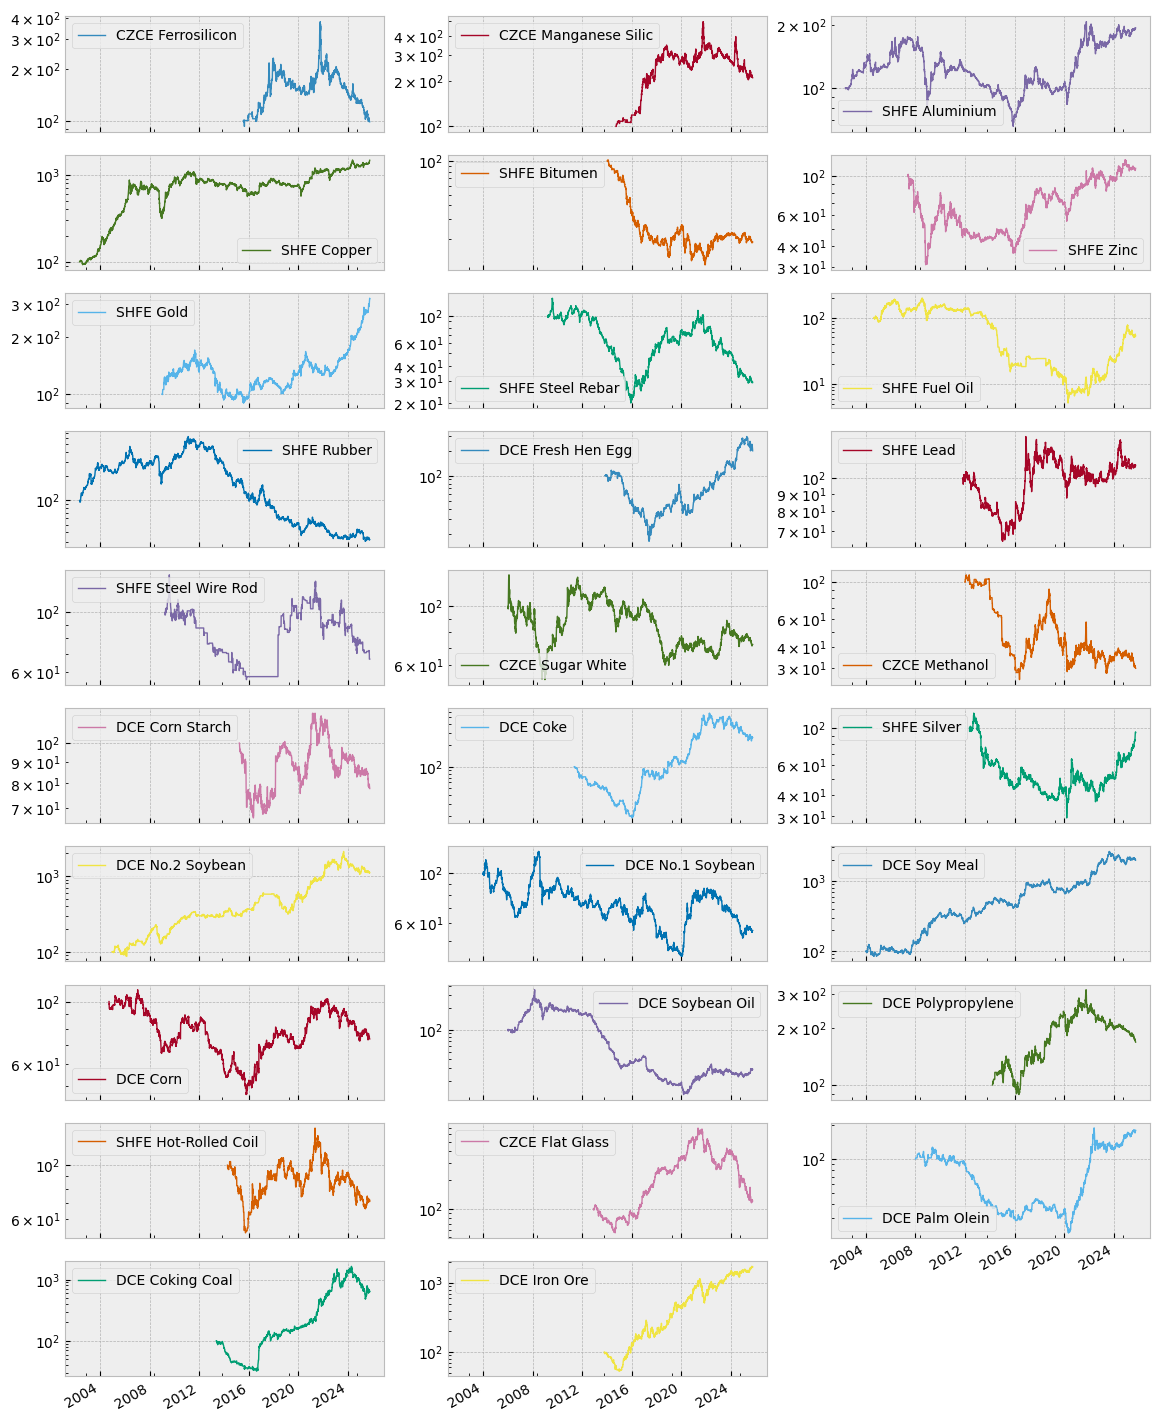

In [5]:
futures_long_only.plot(figsize=(14, 20), subplots=True, layout=(10, 3), lw=1, logy=True);

## Trend following

In Zhang and Zhou (2017), various trend-following signals, including moving averages and price changes, are investigated. However, in this notebook, we employ a simpler rule, as used in the seminal work by Moskowitz (2012), to ensure consistency and assess robustness.

In [6]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_zhang2017.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(agg_method='ewm', com=60, ann_factor=261, 
                               target_volatility=0.4, signal_cap=0.95,
                               post_process=processing.AsFreq(freq='m', method='pad')),
        signal.TSMOMMoskowitz2012(post_process=processing.AsFreq(freq='m', method='pad'))
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine.run()

In [7]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                    .rename('Trend-following portfolio (Zhang and Zhou 2017)'))

Despite differences in methodology, the trend-following portfolio demonstrated strong performance. However, caution is warranted when interpreting these results, as they are calculated gross of transaction costs, and executing trades in these commodity markets may incur higher costs compared to traditional Western commodities. Furthermore, average investors might face challenges accessing Chinese markets due to local regulations.

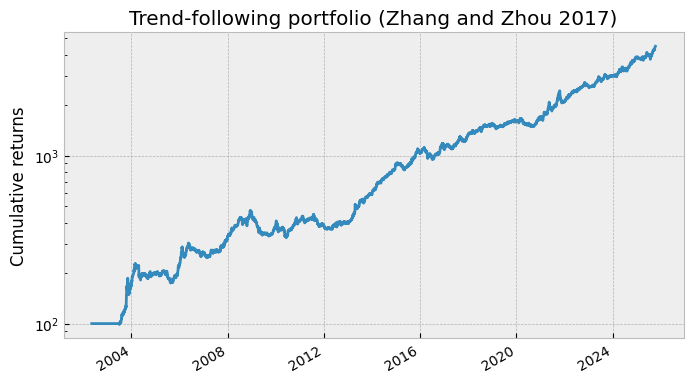

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio (Zhang and Zhou 2017)')
ax.set_ylabel('Cumulative returns');

In [9]:
portfolio_return.pipe(Performance).summary()

,Trend-following portfolio (Zhang and Zhou 2017)
CAGR,0.168656
Annualised vol,0.122708
Sharpe ratio,1.374446
Max drawdown,0.311651
Calmar ratio,0.541168
Skewness,0.092913
Kurtosis,8.096015
Worst return,-0.078959
Worst 1d return,-0.078959
Worst 1w return,-0.128179


## Breakdown by individual contract

Similar to the finding in Moskowitz 2012, Chinese commodity futures also exhibited positive Sharpe ratio for the trend-following strategy

In [10]:
instrument_returns = engine.get_return_by_instrument(calculate_net=False).cumsum()

In [11]:
instrument_sharpe = (instrument_returns.pipe(Performance, return_type='diff').summary()
                     .loc[PerfStats.SHARPE.value, :]
                     .to_frame().join(all_futures_zhang2017)
                     .set_index('name')
                     .squeeze())

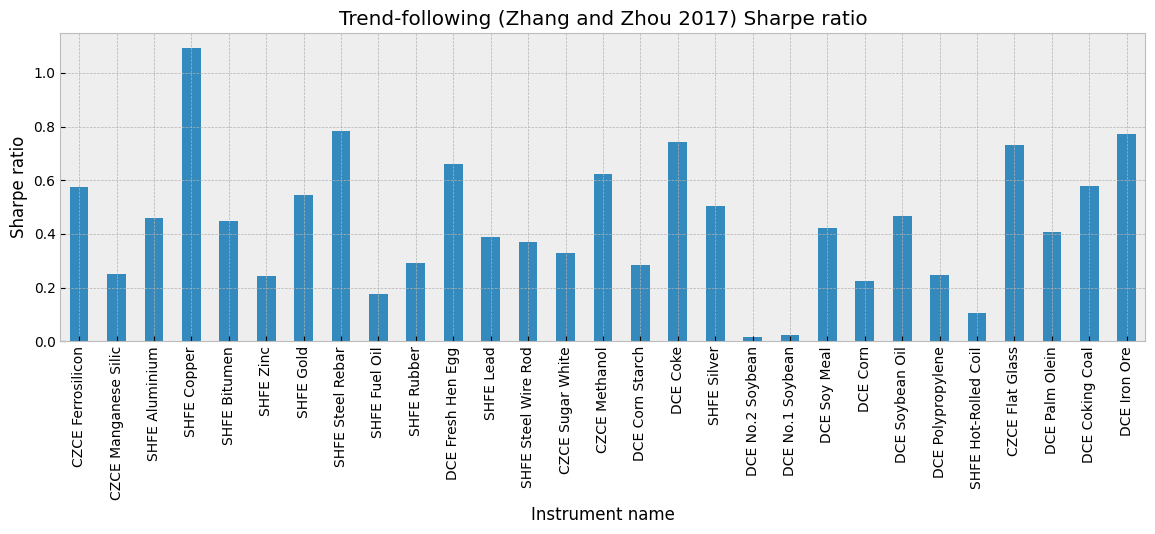

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))
instrument_sharpe.plot(kind='bar', ax=ax)

ax.set_title('Trend-following (Zhang and Zhou 2017) Sharpe ratio')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.set_xlabel('Instrument name');

## Post publication

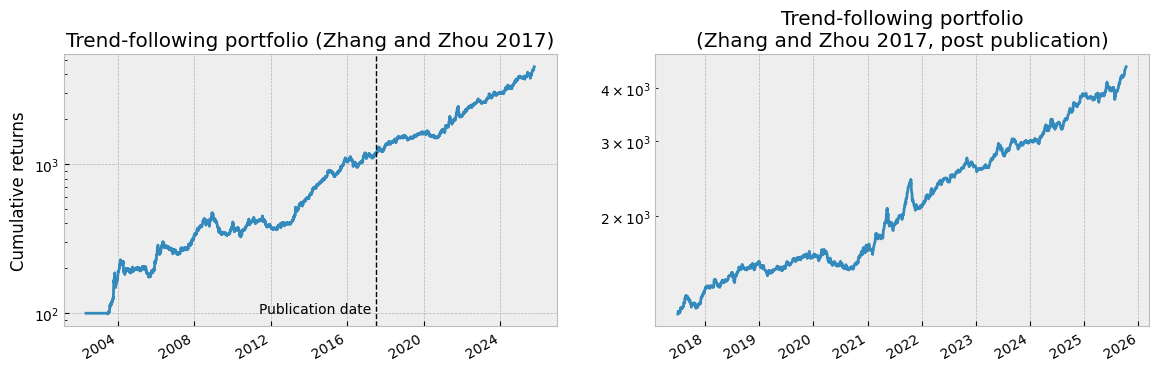

In [13]:
publication_date = datetime(2017, 6, 30)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
portfolio_return.plot(ax=ax[0], logy=True);
ax[0].set_title('Trend-following portfolio (Zhang and Zhou 2017)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

portfolio_return.loc[publication_date:].plot(ax=ax[1], logy=True);
ax[1].set_title('Trend-following portfolio\n(Zhang and Zhou 2017, post publication)');

## Recent performance

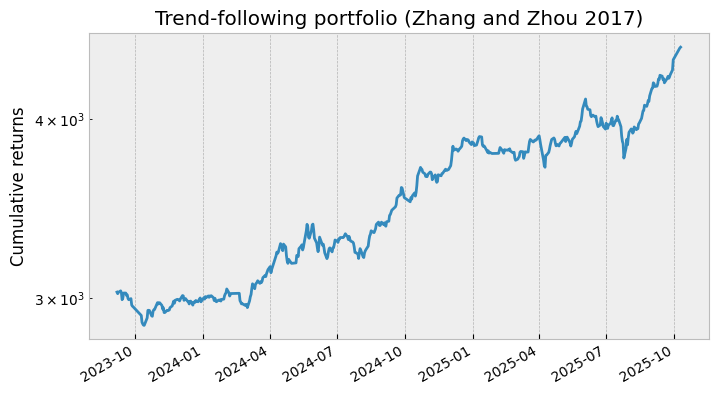

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio (Zhang and Zhou 2017)')
ax.set_ylabel('Cumulative returns');

# Reference

- Li, B., Zhang, D. and Zhou, Y., 2017. Do trend following strategies work in Chinese futures markets?. _Journal of Futures Markets_, _37_(12), pp.1226-1254.
- Moskowitz, T.J., Ooi, Y.H. and Pedersen, L.H., 2012. Time series momentum. Journal of financial economics, 104(2), pp.228-250.

In [15]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 12-Oct-2025 11:10
